In [1]:
from preprocessed_mnist import load_dataset
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
import time

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

#Flattening data
X_train, X_val, X_test   = X_train.reshape(-1, 784), X_val.reshape(-1, 784), X_test.reshape(-1, 784)
y_train, y_val, y_test = y_train.reshape(-1, 1), y_val.reshape(-1, 1), y_test.reshape(-1, 1)

#One Hot encoding
enc = OneHotEncoder()
enc.fit(y_train)
y_train = enc.transform(y_train).toarray()
y_val = enc.transform(y_val).toarray()
y_test = enc.transform(y_test).toarray()

#Drawing mini-batches from training data
def random_mini_batches(X_train, y_train, minibatch_size, seed):
    X_train, y_train = shuffle(X_train, y_train, random_state=seed)
    mini_batches = [(X_train[k:k+minibatch_size,:], y_train[k:k+minibatch_size,:]) 
                    for k in range(0, X_train.shape[0], minibatch_size)]
    
    return mini_batches

Using TensorFlow backend.


11485184/11490434 [============================>.] - ETA: 0s

In [2]:
def model(X_train, y_train, X_val, y_val, X_test, y_test, 
          learning_rate = 0.001, 
          num_epochs = 6,
          minibatch_size = 16, 
          hidden_neurons = 100):
    
    seed = 0 #mini-batch seed
    train_losses = [] #for plotting
    test_losses = []
    
    #Placeholders for the input data
    X = tf.placeholder('float32', shape=(None, X_train.shape[1]))
    Y = tf.placeholder('float32', shape=(None, 10))
    
    #Initializing weights and biases
    init = tf.contrib.layers.xavier_initializer(seed=0)
        
    W1 = tf.get_variable('W1', [784, hidden_neurons], initializer = init)
    W2 = tf.get_variable('W2', [hidden_neurons, 10], initializer = init)
    
    b1 = tf.get_variable('b1', [1, hidden_neurons], initializer = init)
    b2 = tf.get_variable('b2', [1, 10], initializer = init)    
    
    #Forward pass    
    A1 = tf.nn.relu(tf.matmul(X, W1) + b1)
    Z2 = tf.matmul(A1, W2) + b2
    
    #Calculating loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z2, labels = Y))
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    init = tf.global_variables_initializer()
      
    with tf.Session() as sess:     
        sess.run(init)
        
        for epoch in range(num_epochs):             
            num_minibatches = int(X_train.shape[0]/minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, y_train, minibatch_size, seed)
            
            for minibatch in minibatches:              
                (minibatch_X, minibatch_Y) = minibatch
                sess.run(optimizer, {X: minibatch_X, Y: minibatch_Y})
                
            train_loss = sess.run(loss, {X: X_train, Y: y_train})
            val_loss = sess.run(loss, {X: X_val, Y: y_val})
            test_loss = sess.run(loss, {X: X_test, Y: y_test})
            print ("Epoch %i  train loss: %f  validation loss: %f" % (epoch, train_loss, val_loss))
            train_losses.append(train_loss)
            test_losses.append(test_loss)                             
       
        #Plotting loss
        plt.plot(np.squeeze(train_losses))
        plt.plot(np.squeeze(test_losses))
        plt.ylabel('loss')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        #Predictions
        prediction = tf.argmax(Z2, 1)        
        correct_prediction = tf.equal(prediction, tf.argmax(Y, 1))
        
        #Calculating accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
        train_accuracy = accuracy.eval({X: X_train, Y: y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)

Epoch 0  train loss: 0.255136  validation loss: 0.241552
Epoch 1  train loss: 0.185630  validation loss: 0.180846
Epoch 2  train loss: 0.147807  validation loss: 0.151466
Epoch 3  train loss: 0.122698  validation loss: 0.132958
Epoch 4  train loss: 0.102262  validation loss: 0.118010
Epoch 5  train loss: 0.089234  validation loss: 0.108518
Epoch 6  train loss: 0.076817  validation loss: 0.101548
Epoch 7  train loss: 0.066998  validation loss: 0.096988
Epoch 8  train loss: 0.063401  validation loss: 0.096358
Epoch 9  train loss: 0.053083  validation loss: 0.090188
Epoch 10  train loss: 0.048313  validation loss: 0.089297
Epoch 11  train loss: 0.041713  validation loss: 0.083673
Epoch 12  train loss: 0.040943  validation loss: 0.088650
Epoch 13  train loss: 0.034247  validation loss: 0.082668
Epoch 14  train loss: 0.032466  validation loss: 0.081341
Epoch 15  train loss: 0.027829  validation loss: 0.078748
Epoch 16  train loss: 0.025760  validation loss: 0.079865
Epoch 17  train loss: 0.

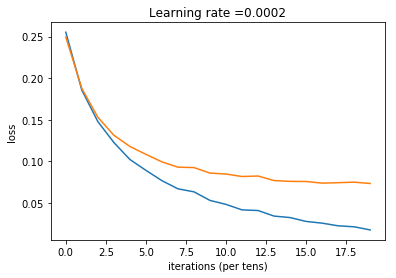

Train Accuracy: 0.99706
Test Accuracy: 0.9785
Training time: 2.8 minutes


In [3]:
tf.reset_default_graph()

tick = time.time()

model(X_train, y_train, X_val, y_val, X_test, y_test, 
      learning_rate= 0.0002, 
      num_epochs = 20,
      minibatch_size = 16, 
      hidden_neurons = 100)

tock = time.time()

print("Training time: %2.1f minutes"%((tock-tick)/60))